In [1]:
import math
import numpy as np
import itertools

import pandas as pd
from pandas.plotting import scatter_matrix

from matplotlib import pyplot as plt
from matplotlib import cm as cm

from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# file locations
dirpath = "/Users/ymkim/Desktop/inf552-hw3-workspace/data/"
filename = "communities.csv"

# files used by question 2
train_filename2 = "aps_failure_training_set.csv"
test_filename2 = "aps_failure_test_set.csv"

In [3]:
# helper functions

# Return numpy array of csv dataset
def csv_to_df(filepath, attr_list, n, p):
    df = pd.read_csv(filepath, header=None)
    df = df.replace(to_replace='?', value="NaN")

    # convert col 3 (start index 0) community name to numerical
    # https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
    df[3] = df[3].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    # assert on n num of instances and p num of attributes
    assert(df.shape[0] == n), "ERROR: invalid num of instances"
    assert(df.shape[1] == p), "ERROR: invalid num of features"

    df.columns = attr_list
    return df

# txt extracted from communities.names
# return attributes list from attributes.txt
def get_attributes(dirpath, filename):
    with open(dirpath + "attributes.txt") as fp:
       content = fp.readlines()
    content = [x.strip() for x in content]

    attributes = []
    for line in content:
        temp = line.split(' ')
        attributes.append(temp[1])

    return attributes

# plot correlation matrix
# ref source: https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas
def correlation_matrix(df):
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('brg', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Matrix')

    plt.xticks(range(len(df.columns)), df.columns, fontsize=5, rotation=90)
    plt.yticks(range(len(df.columns)), df.columns, fontsize=5)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1.0,-0.5,0,0.5,1], fraction=0.046)

    plt.tight_layout()
    plt.show()
    
# return DataFrame (128 rows x 1 col) of Coefficient of Variation (CV) for each features
def get_cv(df):
    mean_df = df.mean(axis=0) # sample mean of each feature
    var_df = df.var(axis=0) # sample variance of each feature

    # coefficient of variation CV of each feature
    cv_list = []
    for i in range(len(df.columns)):
        # sample var / m sample mean
        cv_list.append(var_df[i] / mean_df[i])

    cv_df = pd.DataFrame(cv_list, columns=['CV'])
    cv_df.index = df.columns

    return cv_df

# plot pairwise scatter plots of top features with high CV
# ref source: https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas
def plot_scatter1e(df, features):
    axs = scatter_matrix(df[features], alpha=0.5, figsize = (12, 10))
    n = len(features)
    for x in range(n):
        for y in range(n):
            ax = axs[x, y] # axis of subplots
            ax.xaxis.label.set_rotation(45)
            ax.yaxis.label.set_rotation(45)
            ax.yaxis.label.set_size(8)
            ax.xaxis.label.set_size(8)
            ax.yaxis.labelpad = 50

    plt.suptitle("Pairwise Scatter Plot of Top Features (CV)")
    plt.show()

    # plot boxplots of top features with highest CV
def plot_boxplot1e(df, features):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
    fig.delaxes(axes[2][3])

    for i in range(len(features)):
        row = i // 4
        col = i % 4
        boxplot = df.boxplot(column=features[i], ax=axes[row,col])

    plt.suptitle('Box Plots of Top Features (CV)')
    plt.show()
    
# return feature given the coef values from model
def get_reduced_features(coef, features):
    sel_features = []
    for i in range(len(coef)):
        if coef[i] != 0:
            sel_features.append(features[i])
    return sel_features


# return Dataframe of csv file for problem 2
def csv_to_df2(filepath, n, p):
    df = pd.read_csv(filepath, skiprows=np.arange(0,20,1))
    df = df.replace(to_replace='na', value="NaN")

    # convert col 'class' neg/pos to numerical 0/1
    # https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
    df['class'] = df['class'].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

    # assert on n num of instances and p num of attributes
    assert(df.shape[0] == n), "ERROR: invalid num of instances"
    assert(df.shape[1] == p), "ERROR: invalid num of features"

    return df

# plot pairwise scatter plots of top features with high CV
# ref source: https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas
def plot_scatter2b(df, features):
    axs = scatter_matrix(df[features], alpha=0.5, figsize = (12, 10))
    n = len(features)
    for x in range(n):
        for y in range(n):
            ax = axs[x, y] # axis of subplots
            ax.xaxis.label.set_rotation(45)
            ax.yaxis.label.set_rotation(45)
            ax.yaxis.label.set_size(6)
            ax.xaxis.label.set_size(6)
            ax.yaxis.labelpad = 20
            ax.xaxis.labelpad = 20

    plt.suptitle("Pairwise Scatter Plot of Top Features (CV)")
    plt.show()

# plot boxplots of top features with highest CV
def plot_boxplot2b(df, features):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    fig.delaxes(axes[3][1])
    fig.delaxes(axes[3][2])
    fig.delaxes(axes[3][3])

    for i in range(len(features)):
        row = i // 4
        col = i % 4
        boxplot = df.boxplot(column=features[i], ax=axes[row,col])

    plt.suptitle('Box Plots of Top Features (CV)')
    plt.show()
    
# given confusion matrix, plot confusion matrix
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix_2c(cm, classes, cmap=plt.cm.Blues):
    plt.figure()
    plt.title("Confusion Matrix")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# given y_score from trained model, and y_test labels, plot ROC and AUC
# binary class only
def plot_roc_2c(y_true, y_score, pos_label):
    # y_score is score/prob in the positive class
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC/AUC Plot")
    plt.show()

(1a) LASSO and Boosting for Regression

Data: Communities and Crime Data
    
source: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
        

In [6]:
# (1a) cont.

# 5 non-predictive features (state, county, community, communityname, fold)
# 122 predicitive features
# 1 goal = ViolentCrimesPerPop (want to predict)

# parse csv file to pandas dataframe
# parse attributes.txt from communities.names file
attr_list = get_attributes(dirpath, "attributes.txt")
df = csv_to_df(dirpath + filename, attr_list, 1994, 128)
attr_list = attr_list[5:] # drop 5 non-predictive features
df = df[attr_list] 

# (1b) Data Imputation, missing values in dataset
imp = Imputer(missing_values="NaN", strategy='mean', axis=0)
imp_data = imp.fit_transform(df)

# new dataset dataframe with no missing data
imp_df = pd.DataFrame(imp_data, columns=attr_list) 

ssize = 1495 # split size
train_data = imp_data[:ssize]
test_data = imp_data[ssize:]

# training data
X_train = train_data[:,:122]
y_train = train_data[:,122] # last col - ViolentCrimesPerPop

# test data
X_test = test_data[:,:122]
y_test = test_data[:,122]

print("size of train:", train_data.shape[0])
print("size of test:", test_data.shape[0])
print("num of features:", imp_data.shape[1])

size of train: 1495
size of test: 499
num of features: 123


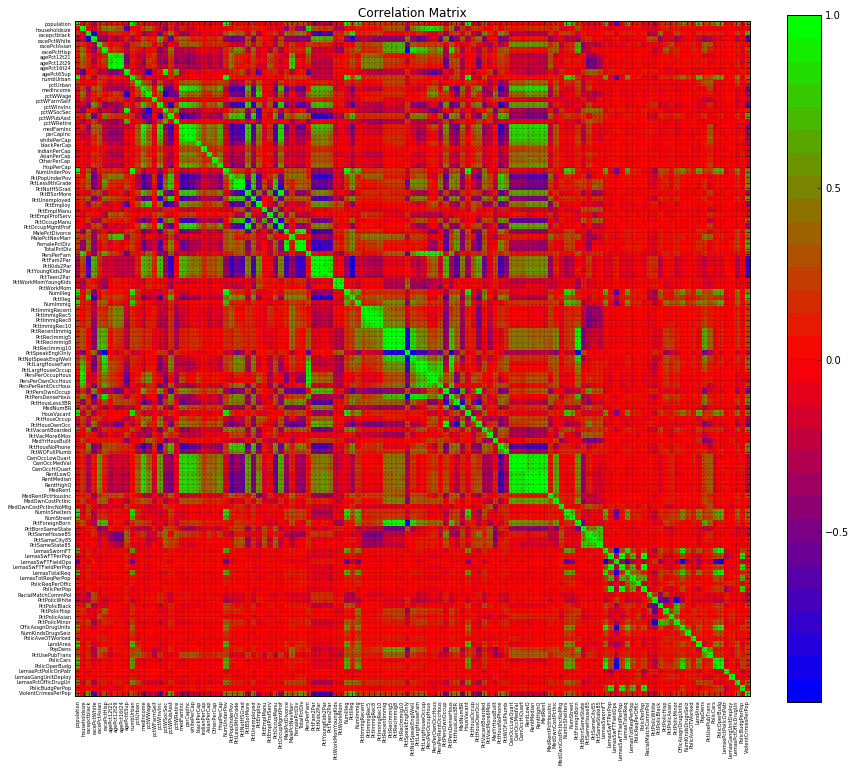

In [79]:
# (1c) Correlation Matrix

# plot correlation matrix
correlation_matrix(imp_df)

In [80]:
# (1d) Coefficient of Variation (CV) for each feature
# CV = sample variance / sample mean

# coefficient of variation CV of each feature
cv_df = get_cv(imp_df)
print(cv_df)

                            CV
population            0.279637
householdsize         0.057841
racepctblack          0.357587
racePctWhite          0.079015
racePctAsian          0.283898
racePctHisp           0.375306
agePct12t21           0.056777
agePct12t29           0.041733
agePct16t24           0.082446
agePct65up            0.075875
numbUrban             0.256736
pctUrban              0.284167
medIncome             0.121379
pctWWage              0.059942
pctWFarmSelf          0.142881
pctWInvInc            0.063970
pctWSocSec            0.063981
pctWPubAsst           0.155280
pctWRetire            0.058587
medFamInc             0.104626
perCapInc             0.104275
whitePerCap           0.094813
blackPerCap           0.101149
indianPerCap          0.133416
AsianPerCap           0.118457
OtherPerCap           0.128067
HispPerCap            0.086773
NumUnderPov           0.294900
PctPopUnderPov        0.172265
PctLess9thGrade       0.144146
...                        ...
PctSameH

Selected Features with highest CV:
['LemasPctOfficDrugUn', 'NumStreet', 'racePctHisp', 'NumInShelters', 'racepctblack', 'NumIlleg', 'PctUsePubTrans', 'PctNotSpeakEnglWell', 'PctRecImmig5', 'PctRecentImmig', 'PctRecImmig8']


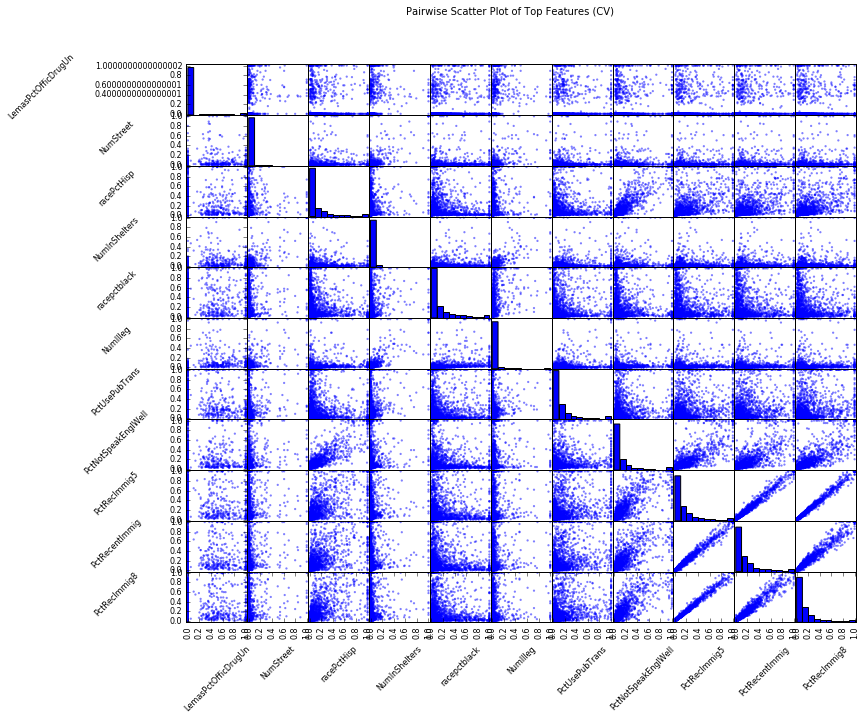

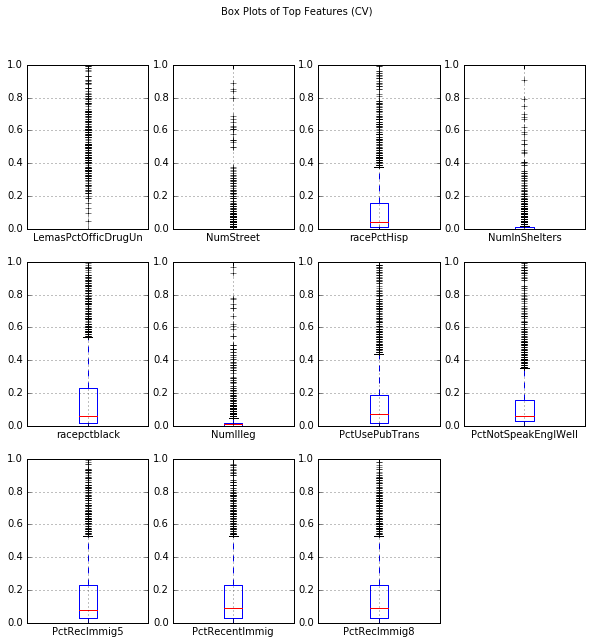

In [81]:
# (1e) Scatter plots and Box plots for Features with highest CV

# Pick floor(sqrt(128)) Features with highest CV
fsize = math.floor(math.sqrt(len(attr_list))) 
top_cv_features = list(cv_df.nlargest(fsize, 'CV').index)
print("Selected Features with highest CV:")
print(top_cv_features)

# Pairwise Scatter Plot
plot_scatter1e(imp_df, top_cv_features)

# Boxplots
plot_boxplot1e(imp_df, top_cv_features)

(1e) cont.

We can draw some conclusions about the significance of the selected features by looking that the pairwise scatter plots. We see that the combinations of 'PctRecImmig5', 'PctRecentImmig', and 'PctRecImmig8' display a strong linear relationship. From this, we can possibly conclude that those features are correlated. 


In [82]:
# (1f) Linear Model (OLS)

# Least Squares Linear Regression
regrOLS = linear_model.LinearRegression()
regrOLS.fit(X_train, y_train)
y_pred = regrOLS.predict(X_test)

print("Linear Model - Least Squares")
print("Mean squared error: {:.6f}".format(mean_squared_error(y_test, y_pred)))
print("R^2: {:.6f}".format(r2_score(y_test, y_pred)))


Linear Model - Least Squares
Mean squared error: 0.789726
R^2: -15.606467


In [83]:
# (1g) Ridge Regression Model
# alpha (lambda) regularization strength
# alphas tested on alphas=(0.1, 1.0, 10.0)

# Ridge Regression
regrRidge = linear_model.RidgeCV()
regrRidge.fit(X_train, y_train)
y_pred = regrRidge.predict(X_test)

print("Ridge Regression")
print("RidgeCV alpha(lambda):{:.2f}".format(regrRidge.alpha_))
print("Mean squared error: {:.6f}".format(mean_squared_error(y_test, y_pred)))
print("R^2: {:.6f}".format(r2_score(y_test, y_pred)))

Ridge Regression
RidgeCV alpha(lambda):1.00
Mean squared error: 0.017737
R^2: 0.627022


In [93]:
# (1h) Lasso Regression Model
# alphas tested on eps=0.001, n_alphas=100

# LASSO
regrLasso = linear_model.LassoCV(max_iter=10000)
regrLasso.fit(X_train, y_train)
y_pred = regrLasso.predict(X_test)

print("Lasso Regression")
print("LassoCV alpha(lambda): {:.6f}".format(regrLasso.alpha_))
print("Mean squared error: {:.6f}".format(mean_squared_error(y_test, y_pred)))
print("R^2: {:.6f}".format(r2_score(y_test, y_pred)))

sel_features = get_reduced_features(regrLasso.coef_, attr_list)
print("Selected Features[{}]:".format(len(sel_features)))
print(sel_features)
print("")

# Normalized features LASSO
regrLasso = linear_model.LassoCV(normalize=True, max_iter=10000)
regrLasso.fit(X_train, y_train)
y_pred = regrLasso.predict(X_test)

print("Lasso Regression (Normalized)")
print("LassoCV alpha(lambda): {:.6f}".format(regrLasso.alpha_))
print("Mean squared error: {:.6f}".format(mean_squared_error(y_test, y_pred)))
print("R^2: {:.6f}".format(r2_score(y_test, y_pred)))

sel_features = get_reduced_features(regrLasso.coef_, attr_list)
print("Selected Features[{}]:".format(len(sel_features)))
print(sel_features)


Lasso Regression
LassoCV alpha(lambda): 0.000308
Mean squared error: 0.017571
R^2: 0.630504
Selected Features[46]:
['racepctblack', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWPubAsst', 'pctWRetire', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctEmploy', 'MalePctDivorce', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'PctIlleg', 'PctImmigRec5', 'PctRecImmig10', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'PctSameCity85', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PopDens', 'PctUsePubTrans', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn']

Lasso Regression (Normalized)
LassoCV alpha(lambda): 0.000085
Mean squared error: 0.017510
R^2: 0.631805
Selected Featu

(1h) cont.

Comparing Lasso and Lasso (normalized), there is a minimal improvement in test MSE. However, Lasso (not normalized) required a stronger regularization constant (alpha or lambda) than that of Lasso (normalized) to achieve similar MSE. Additionally, Lasso (normalized) was able to reduce the number of significant features to 34, whereas Lasso (not normalized) was able to reduce to 46. 

In [101]:
# (1i) PCR Model 

# ref source: https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python

mse_dict = {}
kf = KFold(n_splits=5, shuffle=True)
# cross-validate on number of components 1 to 10
for i in np.arange(1, 11):
    pls = PLSRegression(n_components=i, scale=True) # for PCA want to standarize features
    pls.fit(X_train, y_train)
    score = cross_val_score(pls, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    mse_dict[i] = -score

opt_m = min(mse_dict, key= mse_dict.get) # component with lowest CV MSE 

print("PCR Model using PLS:")
print("M (num of principle component):", opt_m)

# obtain test error (MSE) with CV'ed M component
pls = PLSRegression(n_components=i, scale=True)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
print("Mean squared error: {:.6}".format(mean_squared_error(y_test, y_pred)))


PCR Model using PLS:
M (num of principle component): 5
Mean squared error: 0.0185243


In [102]:
# (1j) XGBoost fit model tree

import xgboost as xgb

# alpha values from 0.01 to 1000 up to 100 values log scale
alphalist = np.logspace(-2, 4, 100, endpoint=True)

mse_dict = {}
kf = KFold(n_splits=5, shuffle=True)
# cross-validate on alpha (regularization strenght) from alphalist
for i in alphalist:
    bst = xgb.sklearn.XGBRegressor(reg_alpha=i)
    bst.fit(X_train, y_train)
    score = cross_val_score(bst, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    mse_dict[i] = -score

opt_a = min(mse_dict, key= mse_dict.get)

print("XGBoost Model:")
print("alpha (lambda) from CV: {:.6}".format(opt_a))

# obtain test MSE with CV'ed alpha value
bst = xgb.sklearn.XGBRegressor(reg_alpha=opt_a)
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print("Mean squared error: {:.6}".format(mean_squared_error(y_test, y_pred)))



XGBoost Model:
alpha (lambda) from CV: 0.756463
Mean squared error: 0.0167556


(2a) Tree-Based Methods

Data: APS Failure at Scania Trucks

source: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks


In [7]:
# (2a) cont.

df_train = csv_to_df2(dirpath + train_filename2, n=60000, p=171)
df_test = csv_to_df2(dirpath + test_filename2, n=16000, p=171)

attr_list = df_train.columns[1:] # feature list

In [8]:
# (2b - i) Data Imputation, handle missing values

imp = Imputer(missing_values="NaN", strategy='mean', axis=0)
imp_train = imp.fit_transform(df_train)
imp_test = imp.fit_transform(df_test)

X_train2 = imp_train[:,1:]
y_train2 = imp_train[:,0] # first col is labels neg/pos as 0/1

X_test2 = imp_test[:,1:]
y_test2 = imp_test[:,0]

# new dataframe with no missing data
imp_df_train = pd.DataFrame(imp_train, columns=df_train.columns)
imp_df_test = pd.DataFrame(imp_test, columns=df_test.columns)

print("size of train:", imp_train.shape[0])
print("size of test:", imp_test.shape[0])
print("num of features:", len(attr_list))

size of train: 60000
size of test: 16000
num of features: 170


In [113]:
# (2b - ii) Calculate Coefficient of Variation (CV)

# coefficient of variation CV of each feature
cv_df2 = get_cv(imp_df_train[attr_list])
print(cv_df2)

                  CV
aa_000  3.564400e+05
ab_000  3.866513e+00
ac_000  1.676075e+09
ad_000  6.442968e+09
ae_000  3.667462e+03
af_000  3.832082e+03
ag_000  1.870981e+06
ag_001  1.185373e+06
ag_002  2.596324e+06
ag_003  6.476318e+06
ag_004  1.275272e+07
ag_005  9.496401e+06
ag_006  9.115815e+06
ag_007  4.008775e+06
ag_008  1.347348e+06
ag_009  5.564685e+06
ah_000  9.576095e+06
ai_000  2.925615e+06
aj_000  2.194254e+06
ak_000  5.440310e+06
al_000  4.869052e+06
am_0    7.654622e+06
an_000  1.734745e+07
ao_000  1.533729e+07
ap_000  9.397413e+06
aq_000  3.567282e+06
ar_000  5.835892e+01
as_000  9.464533e+05
at_000  2.791373e+06
au_000  1.071244e+06
...              ...
dl_000  3.925062e+07
dm_000  9.071971e+06
dn_000  2.775310e+05
do_000  1.256424e+05
dp_000  2.671582e+04
dq_000  2.002817e+09
dr_000  8.742383e+06
ds_000  4.615217e+05
dt_000  7.080154e+04
du_000  3.147148e+07
dv_000  6.974574e+06
dx_000  2.078979e+07
dy_000  4.306436e+05
dz_000  5.180818e+02
ea_000  1.744720e+03
eb_000  1.754

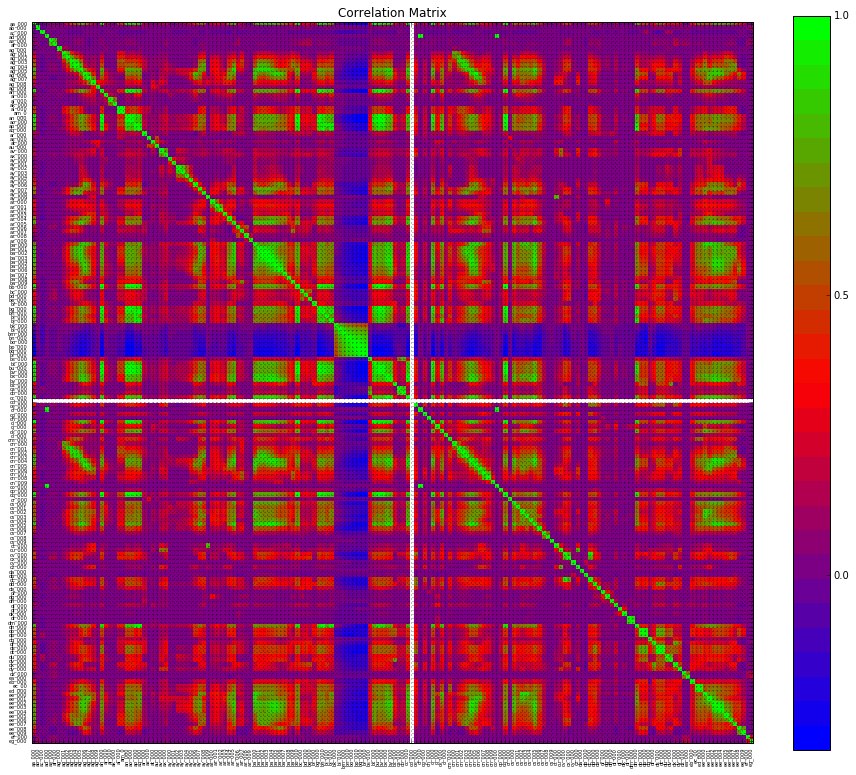

In [114]:
# (2b - iii) Correlation Matrix

# plot correlation matrix
correlation_matrix(imp_df_train[attr_list])

Selected Features with highest CV:
['cf_000', 'co_000', 'ad_000', 'dq_000', 'ac_000', 'eb_000', 'dh_000', 'cs_009', 'dl_000', 'du_000', 'ay_001', 'bb_000', 'bu_000']


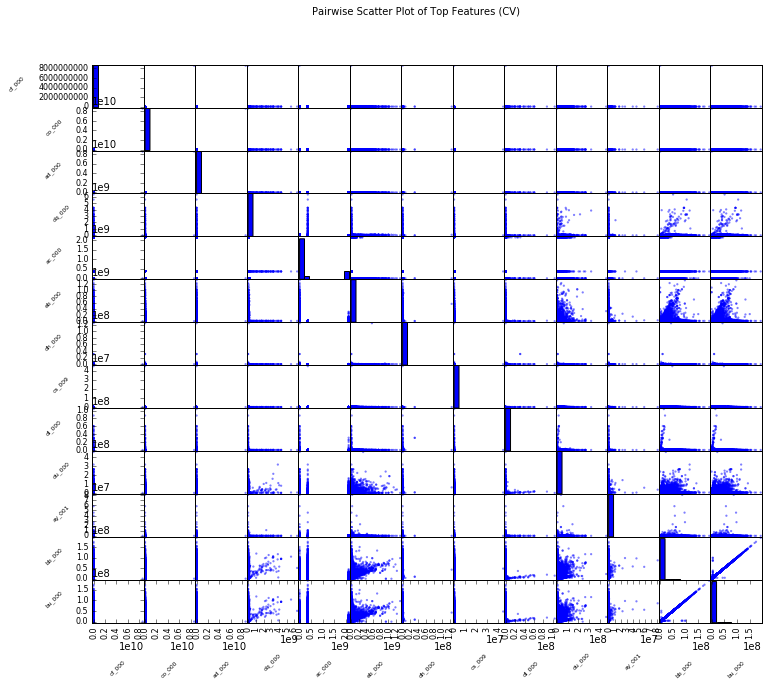

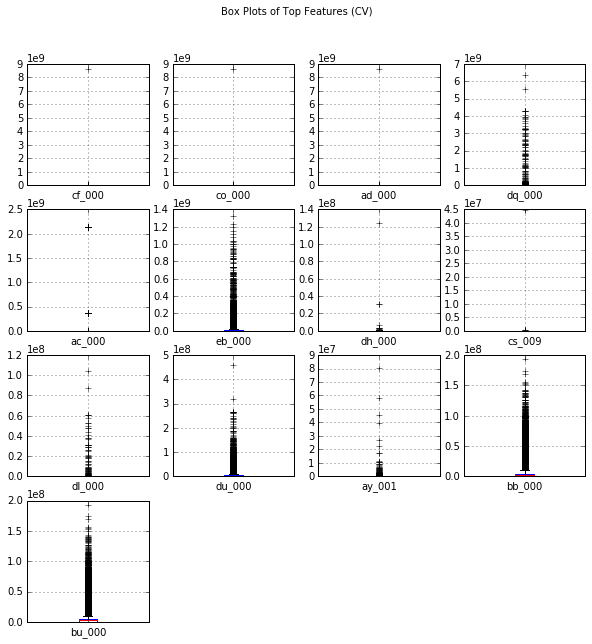

In [119]:
# (2b - iv) Scatter plots and Box plots for Features with highest CV

# Pick floor(sqrt(170)) Features with highest CV
fsize2 = math.floor(math.sqrt(len(attr_list))) 
top_cv_features2 = list(cv_df2.nlargest(fsize2, 'CV').index)
print("Selected Features with highest CV:")
print(top_cv_features2)

# Pairwise Scatter Plot
plot_scatter2b(imp_df_train[attr_list], top_cv_features2)

# Boxplots
plot_boxplot2b(imp_df_train[attr_list], top_cv_features2)


(2b - iv) cont.

We can draw some conclusions about the significance of the selected features by looking that the pairwise scatter plots. We see that the combinations of 'bb_000' and 'bu_000' display a strong linear relationship. From this, we can possibly conclude that those features are correlated. 

Additionally, there are many pairwise features on the scatter plots that display horizontal or vertical lines. An example is 'cf_000' and 'dq_000'. 

There are couple pairwise features that display a widely scattered plots such as 'eb_000' and 'du_000'. It represents that these two are probably un-correlated.


In [120]:
# (2b - v) Number of positive and negative class

print("num of neg[0] class:", len(y_train2) - sum(y_train2))
print("num of pos[1] class:", sum(y_train2))


num of neg[0] class: 59000.0
num of pos[1] class: 1000.0


(2b - v) cont.

Yes. There is class imbalance. The positive class is only 1000 while negative class is 59000. The negative class is dominant and the positive class is rare.

Confusion Matrix - Training Set
tn: 59000 fp: 0 fn: 3 tp: 997


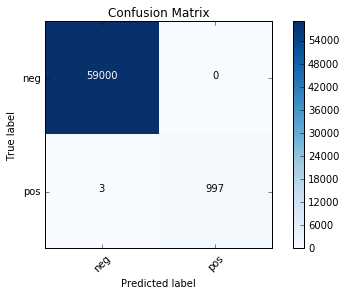

Confusion Matrix - Test Set
tn: 15608 fp: 17 fn: 108 tp: 267


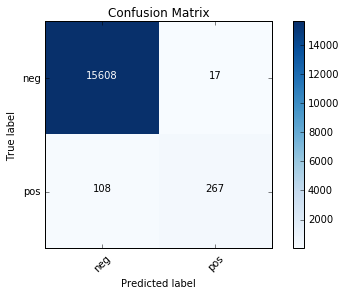

ROC/AUC Plot - Training Set


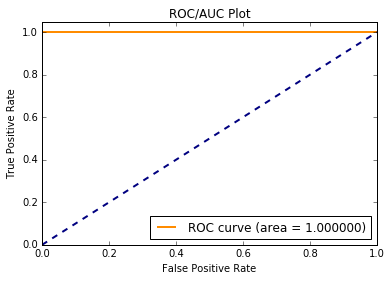

ROC/AUC Plot - Test Set


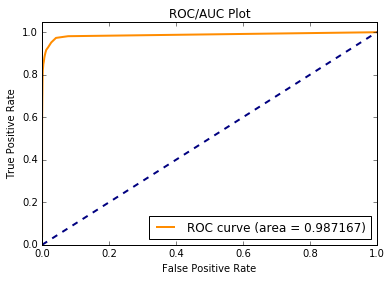

train score: 0.999950
test score: 0.992188
out-of-bag error: 0.993133


In [133]:
# (2c) Train a Random Forest with out compensating for class imbalance

clf = RandomForestClassifier(n_estimators=30, oob_score=True)
clf = clf.fit(X_train2, y_train2)

# Calculate the Confusion Matrix
y_pred_train = clf.predict(X_train2)
y_pred_test = clf.predict(X_test2)

print("Confusion Matrix - Training Set")
cnf_matrix_train = metrics.confusion_matrix(y_train2, y_pred_train)
tn, fp, fn, tp = cnf_matrix_train.ravel()
print("tn: {} fp: {} fn: {} tp: {}".format(tn, fp, fn, tp))
plot_confusion_matrix_2c(cnf_matrix_train, classes=['neg', 'pos'])
print("Confusion Matrix - Test Set")
cnf_matrix_test = metrics.confusion_matrix(y_test2, y_pred_test)
tn, fp, fn, tp = cnf_matrix_test.ravel()
print("tn: {} fp: {} fn: {} tp: {}".format(tn, fp, fn, tp))
plot_confusion_matrix_2c(cnf_matrix_test, classes=['neg', 'pos'])

# Calculate the ROC/AUC
y_train_score = clf.predict_proba(X_train2)
y_test_score = clf.predict_proba(X_test2)

print("ROC/AUC Plot - Training Set")
plot_roc_2c(y_train2, y_train_score[:,1], pos_label=1)
print("ROC/AUC Plot - Test Set")
plot_roc_2c(y_test2, y_test_score[:,1], pos_label=1)

# Misclassification Mean Accuracy
train_mean_accuracy = clf.score(X_train2, y_train2)
test_mean_accuracy = clf.score(X_test2, y_test2)

print("train score: {:.6f}".format(train_mean_accuracy))
print("test score: {:.6f}".format(test_mean_accuracy))
print("out-of-bag error: {:.6f}".format(clf.oob_score_))

(2c) cont.

The default n_estimators (num of trees in the forest) is 10, but it would throw "UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates." In order to prevent this warning message to obtain oob_score, n_estimaters is increased.

Comparing the test score and out-of-bag score, it is relatively similar.

(2d) Addressing Class Imbalance in RandomForest

source ref: http://scikitlearn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score
        
The sklearn package RamdForestClassifier has a parameter called 'class_weight' that helps to target class imbalance. It states that the “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

Confusion Matrix - Training Set
tn: 59000 fp: 0 fn: 6 tp: 994


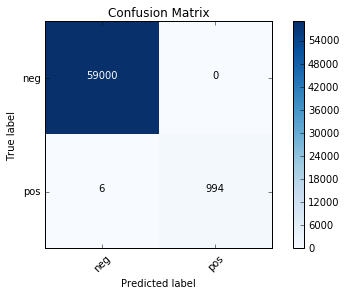

Confusion Matrix - Test Set
tn: 15613 fp: 12 fn: 167 tp: 208


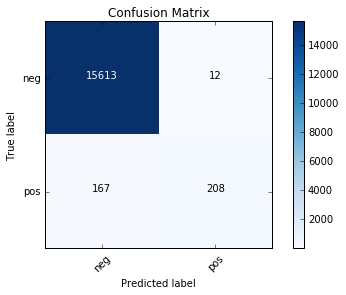

ROC/AUC Plot - Training Set


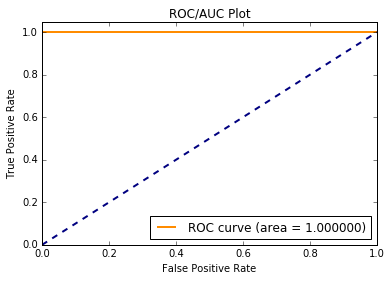

ROC/AUC Plot - Test Set


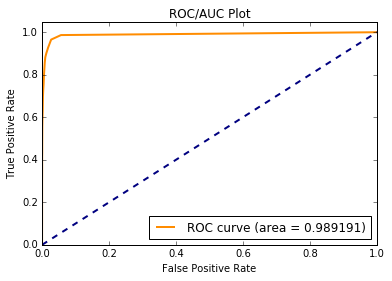

train score: 0.999900
test score: 0.988812
out-of-bag error: 0.991550


In [134]:
# (2d) cont.

clf = RandomForestClassifier(n_estimators=30, oob_score=True, class_weight="balanced")
clf = clf.fit(X_train2, y_train2)

# Calculate the Confusion Matrix
y_pred_train = clf.predict(X_train2)
y_pred_test = clf.predict(X_test2)

print("Confusion Matrix - Training Set")
cnf_matrix_train = metrics.confusion_matrix(y_train2, y_pred_train)
tn, fp, fn, tp = cnf_matrix_train.ravel()
print("tn: {} fp: {} fn: {} tp: {}".format(tn, fp, fn, tp))
plot_confusion_matrix_2c(cnf_matrix_train, classes=['neg', 'pos'])
print("Confusion Matrix - Test Set")
cnf_matrix_test = metrics.confusion_matrix(y_test2, y_pred_test)
tn, fp, fn, tp = cnf_matrix_test.ravel()
print("tn: {} fp: {} fn: {} tp: {}".format(tn, fp, fn, tp))
plot_confusion_matrix_2c(cnf_matrix_test, classes=['neg', 'pos'])

# Calculate the ROC/AUC
y_train_score = clf.predict_proba(X_train2)
y_test_score = clf.predict_proba(X_test2)

print("ROC/AUC Plot - Training Set")
plot_roc_2c(y_train2, y_train_score[:,1], pos_label=1)
print("ROC/AUC Plot - Test Set")
plot_roc_2c(y_test2, y_test_score[:,1], pos_label=1)

# Misclassification Mean Accuracy
train_mean_accuracy = clf.score(X_train2, y_train2)
test_mean_accuracy = clf.score(X_test2, y_test2)

print("train score: {:.6f}".format(train_mean_accuracy))
print("test score: {:.6f}".format(test_mean_accuracy))
print("out-of-bag error: {:.6f}".format(clf.oob_score_))

(2d) cont. Comparison Result from 2c and 2d

<b>2c Results: </b><br>
train score: 0.999950 <br>
test score: 0.992188 <br>
out-of-bag error: 0.993133 <br>
<br>
Confusion Matrix - Training Set <br>
tn: 59000 fp: 0 fn: 3 tp: 997 <br>
Confusion Matrix - Test Set <br>
tn: 15608 fp: 17 fn: 108 tp: 267 <br>

vs. 

<b>2d Results: </b><br>
train score: 0.999900 <br>
test score: 0.988812 <br>
out-of-bag error: 0.991550 <br>

Confusion Matrix - Training Set <br>
tn: 59000 fp: 0 fn: 6 tp: 994 <br>
Confusion Matrix - Test Set <br>
tn: 15613 fp: 12 fn: 167 tp: 208 <br>

By looking at the missclassifcation accuracy scores, we can see that the training error score remains about the same; whereas there 2d (class_weight='balanced') has a slight decrease in test error score 0.988 vs 0.992.

Comparing the Confusion Matrix, we see that in both training and test, there is a slight decrease in tp while a slight increase in fn for 2d (class_weight='balanced').

In [10]:
# (2e) Weka to train Logistic Model Tree

# build arff files for Weka
import arff
arff.dump(dirpath+'aps_failure_training.arff', imp_df_train.values, relation='aps_failure', names=imp_df_train.columns)
arff.dump(dirpath+'aps_failure_test.arff', imp_df_test.values, relation='aps_failure', names=imp_df_test.columns)

# after change @attribute class {0.0, 1.0} in both arff files
# arff dump determined class attribute as real so changed

In [13]:
import traceback
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.plot.classifiers as plcls  # NB: matplotlib is required

train_datapath = dirpath +'aps_failure_training.arff'
test_datapath = dirpath +'aps_failure_test.arff'

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-pac

WEKA Load train data
WEKA Build Classifier Logistic Model Tree
WEKA Performing 5-Fold Cross Validation
Estimated Test Error (Percent Correct): 99.185
Confusion Matrix
[[58828.   172.]
 [  317.   683.]]
ROC/AUC


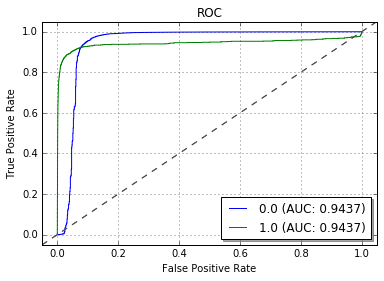

In [21]:
# (2e) cont. (about 2hrs to train and cross-validate)
# on Training Data and Cross Validate for Test Error

try:
    jvm.start()
    
    # load training data
    print("WEKA Load train data")
    loader = Loader(classname="weka.core.converters.ArffLoader")
    train_data = loader.load_file(train_datapath)
    train_data.class_is_first()

    # build classifier Logistic Model Tree
    print("WEKA Build Classifier Logistic Model Tree")
    cls = Classifier(classname="weka.classifiers.trees.LMT")
    cls.build_classifier(train_data)

    # cross validation 5-fold to estimate test error
    print("WEKA Performing 5-Fold Cross Validation")
    evl = Evaluation(train_data)
    evl.crossvalidate_model(cls, train_data, 5, Random(1))

    print("Estimated Test Error (Percent Correct): {:.3f}".format(evl.percent_correct))
    
    print("Confusion Matrix")
    print(evl.confusion_matrix)
    
    print("ROC/AUC")
    plcls.plot_roc(evl, class_index=[0, 1], wait=True)

except Exception as e:
    print(traceback.format_exc())
finally:
    jvm.stop()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-pac

WEKA Load train data
WEKA Load test data
WEKA Build Classifier Logistic Model Tree
WEKA eval classifier on test data
Test Error (Percent Correct): 99.037
Confusion Matrix
[[15579.    46.]
 [  108.   267.]]
ROC/AUC


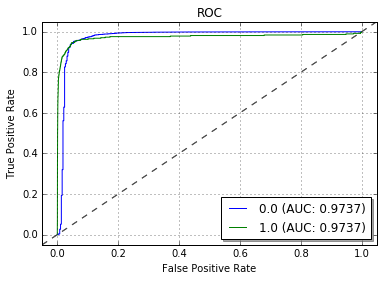

In [22]:
# (2e) cont.
# on Test Data

try:
    jvm.start()
    
    # load training data
    print("WEKA Load train data")
    loader = Loader(classname="weka.core.converters.ArffLoader")
    train_data = loader.load_file(train_datapath)
    train_data.class_is_first()
    
    print("WEKA Load test data")
    test_data = loader.load_file(test_datapath)
    test_data.class_is_first()

    # build classifier Logistic Model Tree
    print("WEKA Build Classifier Logistic Model Tree")
    cls = Classifier(classname="weka.classifiers.trees.LMT")
    cls.build_classifier(train_data)

    # test classifier on test data
    print("WEKA eval classifier on test data")
    evl = Evaluation(train_data)
    evl.test_model(cls, test_data)

    print("Test Error (Percent Correct): {:.3f}".format(evl.percent_correct))
    
    print("Confusion Matrix")
    print(evl.confusion_matrix)
    
    print("ROC/AUC")
    plcls.plot_roc(evl, class_index=[0, 1], wait=True)

except Exception as e:
    print(traceback.format_exc())
finally:
    jvm.stop()

(2e) cont.

The results of Weka Logistic Model Tree for train and test error in terms of percent correct are 99.185 and 99.037, respectively. The train and test errors are quite similar and the test error is expected to be higher than the train error. 

In [23]:
# (2f) SMOTE for class imbalance and redo (2e)

from imblearn.over_sampling import SMOTE
method = SMOTE(kind='regular')
x_res_train, y_res_train = method.fit_sample(X_train2, y_train2)
x_res_test, y_res_test = method.fit_sample(X_test2, y_test2)

label_res_train = y_res_train.reshape(x_res_train.shape[0], 1)
label_res_test = y_res_test.reshape(x_res_test.shape[0], 1)

new_np_train = np.hstack((label_res_train, x_res_train))
new_np_test = np.hstack((label_res_test, x_res_test))

new_df_train = pd.DataFrame(new_np_train, columns=df_train.columns)
new_df_test = pd.DataFrame(new_np_test, columns=df_test.columns)


In [18]:
# (2f) cont.
# build arff files for Weka

arff.dump(dirpath+'aps_failure_training_smote.arff', 
          new_df_train.values, 
          relation='aps_failure', 
          names=new_df_train.columns)

arff.dump(dirpath+'aps_failure_test_smote.arff', 
          new_df_test.values, 
          relation='aps_failure', 
          names=new_df_test.columns)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-pac

WEKA Load SMOTE train data
WEKA Build Classifier Logistic Model Tree
WEKA Performing 5-Fold Cross Validation
Estimated Test Error (Percent Correct): 98.588
Confusion Matrix
[[58022.   978.]
 [  688. 58312.]]
ROC/AUC


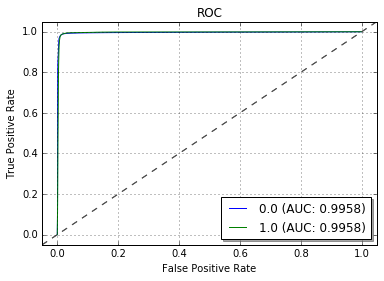

In [24]:
# (2f) cont.
# on SMOTE Training Data and Cross Validate

smote_train_datapath = dirpath +'aps_failure_training_smote.arff'

try:
    jvm.start()
    
    # load training data
    print("WEKA Load SMOTE train data")
    loader = Loader(classname="weka.core.converters.ArffLoader")
    smote_train_data = loader.load_file(smote_train_datapath)
    smote_train_data.class_is_first()

    # build classifier Logistic Model Tree
    print("WEKA Build Classifier Logistic Model Tree")
    cls = Classifier(classname="weka.classifiers.trees.LMT")
    cls.build_classifier(smote_train_data)

    # cross validation 5-fold to estimate test error
    print("WEKA Performing 5-Fold Cross Validation")
    evl = Evaluation(smote_train_data)
    evl.crossvalidate_model(cls, smote_train_data, 5, Random(1))

    print("Estimated Test Error (Percent Correct): {:.3f}".format(evl.percent_correct))
    
    print("Confusion Matrix")
    print(evl.confusion_matrix)
    
    print("ROC/AUC")
    plcls.plot_roc(evl, class_index=[0, 1], wait=True)

except Exception as e:
    print(traceback.format_exc())
finally:
    jvm.stop()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/anaconda3/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/anaconda3/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.6/site-packages/weka/lib/weka.jar', '/anaconda3/lib/python3.6/site-pac

WEKA Load SMOTE train data
WEKA Load SMOTE test data
WEKA Build Classifier Logistic Model Tree
WEKA eval classifier on SMOTE test data
Test Error (Percent Correct): 95.232
Confusion Matrix
[[15106.   519.]
 [  971. 14654.]]
ROC/AUC


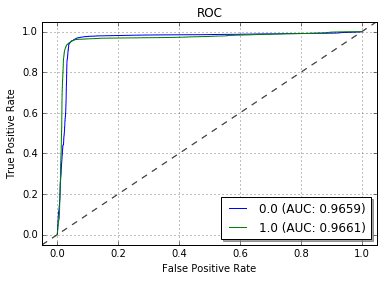

In [25]:
# (2f) cont.
# on SMOTE Test data

smote_test_datapath = dirpath +'aps_failure_test_smote.arff'

try:
    jvm.start()
    
    # load SMOTE training data
    print("WEKA Load SMOTE train data")
    loader = Loader(classname="weka.core.converters.ArffLoader")
    smote_train_data = loader.load_file(smote_train_datapath)
    smote_train_data.class_is_first()
    
    print("WEKA Load SMOTE test data")
    smote_test_data = loader.load_file(smote_test_datapath)
    smote_test_data.class_is_first()

    # build classifier Logistic Model Tree
    print("WEKA Build Classifier Logistic Model Tree")
    cls = Classifier(classname="weka.classifiers.trees.LMT")
    cls.build_classifier(smote_train_data)

    # test classifier on test data
    print("WEKA eval classifier on SMOTE test data")
    evl = Evaluation(smote_train_data)
    evl.test_model(cls, smote_test_data)

    print("Test Error (Percent Correct): {:.3f}".format(evl.percent_correct))
    
    print("Confusion Matrix")
    print(evl.confusion_matrix)
    
    print("ROC/AUC")
    plcls.plot_roc(evl, class_index=[0, 1], wait=True)

except Exception as e:
    print(traceback.format_exc())
finally:
    jvm.stop()

(2f) cont.

The train and test error for WEKA Logistic Model Tree after compensating for class imbalance using SMOTE, the new train and test errors in terms of percent correct are 98.588 and 95.232, respectively. 

We have a lower percent correct (higher error) on the compensated case than that of the uncompensated case as shown in part (2e). The results of train and test errors from (2e) are 99.185 and 99.037. We have increased the number of rare class in the dataset using SMOTE. Even though the test results of SMOTE are lower than the uncompensated case, it did well to classify on the test data (95%).



(3) - 6.8.3

a. training RSS steadily decreases (iv) as s increases from 0. When s is large, it becomes the ordinary least square model, so training RSS will become minimum. When s is subjected to be 0, the sum of B (coefficients) will be 0, making the training RSS large.

b. test RSS decreases initially, and then eventually start increasing in a U shape (ii). As we increase s from 0, it approaches least square model, so the test RSS will decrease and once the model start to overfit, the test RSS will increase, thus the U shape.

c. variance steadily increases (iii). When s increases, it becomes least square model and starts to overfit on training data, so the variance increases. 

d. squared bias steadily decreases (iv). It is the opposite of variance. When s increases and becomes least square model, it fits to training data, so the bias reduces. When s is 0, it restricts the sum of B (coefficients) to be 0, so the model is less flexible, thus resulting in a higher bias. 

e. irreducible error remains constant (v). It is error due to noise, so it is independent to the model and s. 


(4) - 6.8.5

a. training RSS steadily increases (iii) as lambda (ridge) increase from 0. When lambda ia 0, the model is the least square model, so the training RSS will be minimum. However, when lambda increase, the strenght of the regularizer increase, making the coefficient values to be 0, so the training RSS will increase.

b. test RSS decreases initially, and then eventually start increasing in a U shape. When lambda is 0, the model is the least square model. As lambda increases, some of the B coefficents will approach 0 and reduces the inital overfit model. This will lower the test RSS. However, when lambda becomes too large, all the B coefficients begin approach 0 and the test RSS will increase since the model no longer represents the data.

c. variance steadily decreases (iv). As lambda increases from 0, it is equivalent to the least square model approaching to a simpler model where some of the B coefficents approach 0. High variance corresponds to the least square model when its overfitted to the training data, so the variance will decrease as the model becomes more simple.

d. squared bias steadily increases (iii). It is the opposite of variance. The bias will be low when lambda is 0 because it is least square model. Once lambda regularizer increases, the B coefficient values will approach 0, making the model less fit to the training data. This will increase the bias.

e. irreducible error remains constant (v). It is noise and is independent to the model and lambda.


(5) - 8.4.5

Majority Vote results:

0.1, 0.15, 0.2, 0.2 (Not Red) = 4 <br>
0.55, 0.6, 0.6, 0.65, 0.7, 0.75 (Red) = 6 <br>

result is True (Red Class)


Average Probability:

avg(0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75) = 0.45

result is False (Not Red Class)


(6) - 9.7.3

see attachment